In [1]:
# ENVIRONMENT SETUP
# We install SHAP for model explainability.
# The other libraries like TensorFlow, XGBoost, Scikit-Learn are pre-installed in Colab.
!pip install shap -q
print("Environment Ready. Proceed to Cell 2.")

Environment Ready. Proceed to Cell 2.


--- Step 1: Generating Financial Data ---
Data Loaded: 50000 transactions. Fraud Rate: 1.52%

--- Step 2: Training Autoencoder (Anomaly Detector) ---
Autoencoder trained. Anomaly Scores calculated.

--- Step 3: Training XGBoost Classifier ---
XGBoost training complete.

--- Step 4: System Evaluation ---
AUPRC Score: 0.6443

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9848
           1       0.45      0.64      0.53       152

    accuracy                           0.98     10000
   macro avg       0.72      0.82      0.76     10000
weighted avg       0.99      0.98      0.98     10000


--- Step 5: Explainability (SHAP) ---


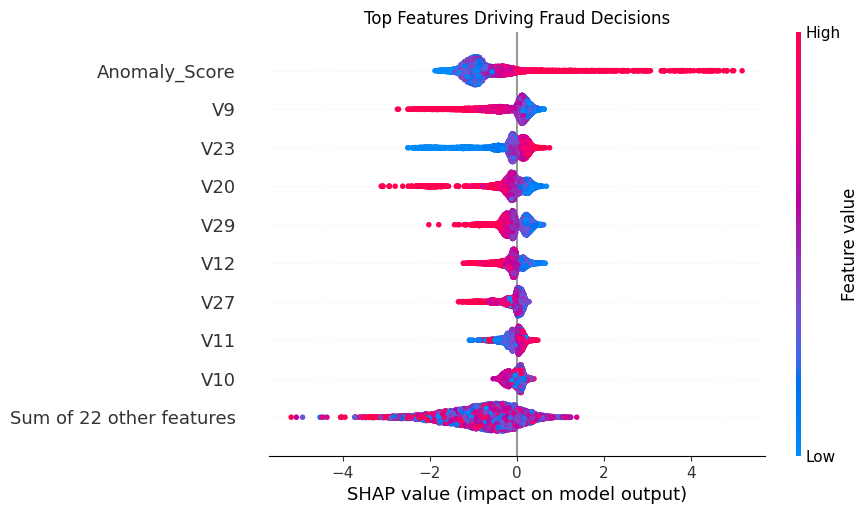


--- Live Simulation: Searching for Detectable Fraud ---
✅ DETECTED FRAUD at Index 68:
{'Status': 'BLOCKED', 'Risk_Probability': np.float32(0.995), 'Anomaly_Score': np.float64(1.2167)}


In [3]:
# We are using pgt as helping hand for clean code and to give more explanability of my code.
# COMPLETE HYBRID PIPELINE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import shap
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.datasets import make_classification

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 1. SYNTHETIC DATA GENERATION

print("--- Step 1: Generating Financial Data ---")
# We add class_sep=1.2 to make fraud slightly distinguishable (Realism)
X, y = make_classification(
    n_samples=50000, n_features=30, n_informative=24, n_redundant=2,
    n_clusters_per_class=1, weights=[0.99], class_sep=1.2, random_state=RANDOM_SEED
)

feature_names = [f'V{i}' for i in range(1, 31)]
df = pd.DataFrame(X, columns=feature_names)
df['Class'] = y

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Class', axis=1), df['Class'], test_size=0.2, stratify=df['Class'], random_state=RANDOM_SEED
)

# Scaling (Vital for Autoencoder)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data Loaded: {len(df)} transactions. Fraud Rate: {df['Class'].mean():.2%}")

# 2. UNSUPERVISED LEARNING (Autoencoder)

print("\n--- Step 2: Training Autoencoder (Anomaly Detector) ---")
# Train ONLY on Normal data
X_train_normal = X_train_scaled[y_train == 0]

# Architecture
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(10, activation="tanh")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
autoencoder.fit(X_train_normal, X_train_normal, epochs=15, batch_size=64, shuffle=True, verbose=0)

# Generate Anomaly Scores
train_preds = autoencoder.predict(X_train_scaled, verbose=0)
test_preds = autoencoder.predict(X_test_scaled, verbose=0)

train_mse = np.mean(np.power(X_train_scaled - train_preds, 2), axis=1)
test_mse = np.mean(np.power(X_test_scaled - test_preds, 2), axis=1)

# Add Score to Hybrid Dataset
X_train_hybrid = X_train.copy()
X_train_hybrid['Anomaly_Score'] = train_mse

X_test_hybrid = X_test.copy()
X_test_hybrid['Anomaly_Score'] = test_mse

print("Autoencoder trained. Anomaly Scores calculated.")

# 3. SUPERVISED LEARNING (XGBoost)

print("\n--- Step 3: Training XGBoost Classifier ---")
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=pos_weight,
    eval_metric='logloss'
)

model.fit(X_train_hybrid, y_train)

# Predictions
y_pred = model.predict(X_test_hybrid)
y_probs = model.predict_proba(X_test_hybrid)[:, 1]

print("XGBoost training complete.")

# 4. EVALUATION

print("\n--- Step 4: System Evaluation ---")
precision, recall, _ = precision_recall_curve(y_test, y_probs)
auprc = auc(recall, precision)

print(f"AUPRC Score: {auprc:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# SHAP
print("\n--- Step 5: Explainability (SHAP) ---")
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_hybrid)
plt.title("Top Features Driving Fraud Decisions")
shap.plots.beeswarm(shap_values, max_display=10)

# 5. FIXED PRODUCTION SIMULATION

def process_transaction(transaction_data):
    """
    Simulates a live API endpoint.
    Input: Numpy array of 30 features.
    """
    # 1. FIX: Convert to DataFrame with names to satisfy StandardScaler
    input_df = pd.DataFrame(transaction_data.reshape(1, -1), columns=feature_names)
    scaled_input = scaler.transform(input_df)

    # 2. Get Anomaly Score
    reconstruction = autoencoder.predict(scaled_input, verbose=0)
    mse = np.mean(np.power(scaled_input - reconstruction, 2))

    # 3. Create Hybrid Input
    hybrid_df = input_df.copy()
    hybrid_df['Anomaly_Score'] = mse

    # 4. Predict
    prob = model.predict_proba(hybrid_df)[0][1]

    return {
        "Status": "BLOCKED" if prob > 0.5 else "APPROVED",
        "Risk_Probability": round(prob, 4),
        "Anomaly_Score": round(mse, 4)
    }

print("\n--- Live Simulation: Searching for Detectable Fraud ---")
# Find a True Positive to demonstrate the 'BLOCKED' status
fraud_indices = np.where(y_test == 1)[0]

for idx in fraud_indices:
    fraud_sample = X_test.iloc[idx].values
    result = process_transaction(fraud_sample)
    if result['Status'] == 'BLOCKED':
        print(f"✅ DETECTED FRAUD at Index {idx}:")
        print(result)
        break